# core

> Fill in a module description here

In [1]:
#| default_exp core

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
from pathlib import Path
import os
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from dataclasses import dataclass, field
from collections import Counter
import shutil

In [5]:
import timm
from fastai.imports import *
from fastai.vision.all import *

In [6]:
rnd_seed = 42
n_s = 5
set_seed(rnd_seed)

In [43]:
!ls {Path.cwd().parent}

RSNA-_Breast_Cancer_Detection  data


In [7]:
data_path = Path.cwd().parent/'data'/'bc_768_roi'
data_train_path = data_path/'train'
data_test_path = data_path/'test'
data_symlink = data_path/'data_symlink'

In [8]:
data_small_train_path = data_path/'train_small'
data_small_train_path.mkdir(exist_ok=True, parents=True)

In [ ]:
# Trying to create a small dataset for faster training

In [46]:
data_train_path.ls()

(#54706) [Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_1459541791.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_1864590858.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_1874946579.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_462822612.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_1031443799.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_220375232.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_270344397.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_541722628.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10025_1365269360.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10025_288394860.png')...]

In [9]:
data_path.ls()

(#5) [Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/sample_submission.csv'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/test.csv'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train.csv.zip')]

In [9]:
df_train = pd.read_csv(data_path/'train.csv.zip')
df_test = pd.read_csv(data_path/'test.csv')

In [15]:
df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [14]:
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [13]:
(
    df_train
    .rename(columns={'cancer': 'target'})
    ['target'].value_counts()
)


0    53548
1     1158
Name: target, dtype: int64

- Let's how many patients are available in training and test set

In [14]:
cols = 'patient_id cancer'.split()
(
    df_train
    .loc[:,'patient_id']
    .value_counts()

)

52868    14
55706    14
9795     13
51115    13
5421     13
         ..
32743     4
32751     4
32763     4
32770     4
9989      4
Name: patient_id, Length: 11913, dtype: int64

- Some patients have 14 images and some has 4 images

# Goal

- Create an effective validation set
- Iterating rapidly to see what makes the best improvement

In [15]:
train_images = get_image_files(data_train_path)

In [16]:
train_images

(#54706) [Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_1459541791.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_1864590858.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_1874946579.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10006_462822612.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_1031443799.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_220375232.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_270344397.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10011_541722628.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10025_1365269360.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train/10025_288394860.png')...]

# See single image

(316, 768)


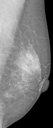

In [17]:
img = PILImage.create(train_images[0])
print(img.size)
img.to_thumb(128)

# Searching for size of images 

In [18]:
from fastcore.parallel import *

In [19]:
def f(o): return PILImage.create(o).size

In [20]:
#sizes = parallel(f, train_images, n_workers=8)

In [21]:
#pd.Series(sizes).value_counts(ascending=True)

In [22]:
one_image = train_images[0]
one_image.name

'10006_1459541791.png'

In [23]:
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


# Getting label function

In [16]:
df_train['image_name'] = df_train['patient_id'].astype(str) + "_"+ df_train['image_id'].astype(str) +".png"

In [17]:
cancer_map = {
             0: 'not cancer',
             1: 'cancer'}

In [18]:
cols = ['image_name', 'cancer']
df_t=(
    df_train
    .loc[:,cols]
)

In [19]:
df_t

,image_name,cancer
0,10006_462822612.png,0
1,10006_1459541791.png,0
2,10006_1864590858.png,0
3,10006_1874946579.png,0
4,10011_220375232.png,0
...,...,...
54701,9973_1729524723.png,0
54702,9989_63473691.png,0
54703,9989_1078943060.png,0
54704,9989_398038886.png,0


In [20]:
df_t['label']= np.where(df_t['cancer'] == 0, 'not cancer', 'cancer')

In [21]:
test = pd.Series(df_t['image_name'].values,index=df_t.label).to_dict()

In [22]:
label_map = pd.Series(df_t['label'].values, index = df_t['image_name']).to_dict()
label_map

{'10006_462822612.png': 'not cancer',
 '10006_1459541791.png': 'not cancer',
 '10006_1864590858.png': 'not cancer',
 '10006_1874946579.png': 'not cancer',
 '10011_220375232.png': 'not cancer',
 '10011_270344397.png': 'not cancer',
 '10011_541722628.png': 'not cancer',
 '10011_1031443799.png': 'not cancer',
 '10025_562340703.png': 'not cancer',
 '10025_1365269360.png': 'not cancer',
 '10025_288394860.png': 'not cancer',
 '10025_893612858.png': 'not cancer',
 '10038_1967300488.png': 'not cancer',
 '10038_2142944869.png': 'not cancer',
 '10038_850559196.png': 'not cancer',
 '10038_1350492010.png': 'not cancer',
 '10042_102733848.png': 'not cancer',
 '10042_202939811.png': 'not cancer',
 '10042_1648588715.png': 'not cancer',
 '10042_294481519.png': 'not cancer',
 '10042_495770405.png': 'not cancer',
 '10048_964141995.png': 'not cancer',
 '10048_1234933874.png': 'not cancer',
 '10048_1577142909.png': 'not cancer',
 '10048_1842203124.png': 'not cancer',
 '10049_349510516.png': 'not cancer',


In [23]:
def label_func(x):
    return label_map[x.name]



In [32]:
one_image = train_images[0]
label_func(one_image)

'not cancer'

In [24]:
df_t.head()

,image_name,cancer,label
0,10006_462822612.png,0,not cancer
1,10006_1459541791.png,0,not cancer
2,10006_1864590858.png,0,not cancer
3,10006_1874946579.png,0,not cancer
4,10011_220375232.png,0,not cancer


# DataLoaders

In [25]:
dls = ImageDataLoaders.from_path_func(
                                data_train_path,
                                fnames=train_images,
                                label_func=label_func,
                                valid_pct=0.2,
                                seed=42,
                                item_tfms=Resize(166, method='squish'),
                                batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.device = default_device()

NameError: name 'train_images' is not defined

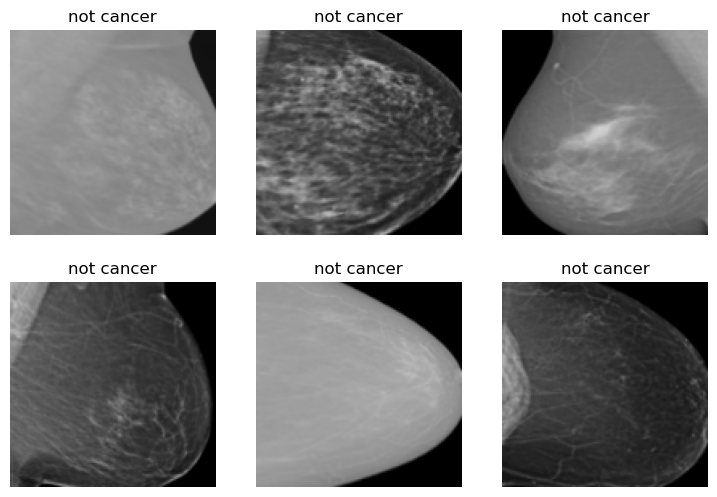

In [35]:
dls.show_batch(max_n=6)

In [36]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.02290867641568184, slide=0.03981071710586548)

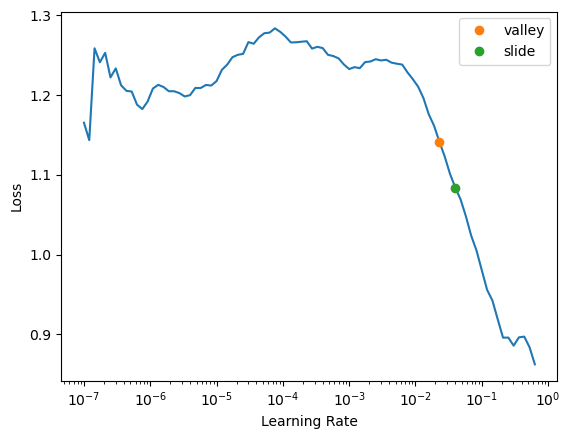

In [37]:
learn.lr_find(suggest_funcs=(valley, slide))

In [38]:
learn.fine_tune(1, 0.01)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

- taking lots of time
- let's see whether we can remove resizing first and then try to see whether it gets faster

In [ ]:
resize_images(
            data_train_path,
            dest=data_small_train_path,
            max_size=256,
            recurse=True)

In [50]:
data_small_train_path.ls()

(#54706) [Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10006_1459541791.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10006_1864590858.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10006_1874946579.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10006_462822612.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10011_1031443799.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10011_220375232.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10011_270344397.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10011_541722628.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10025_1365269360.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/10025_288394860.png')...]

In [52]:
dls_f = ImageDataLoaders.from_path_func(
                                      data_small_train_path,
                                      fnames=get_image_files(data_small_train_path),
                                      label_func=label_func,
                                      valid_pct=0.2,
                                      seed=42,
                                      item_tfms=Resize((256,192))
                                      )
dls_f.device = default_device()

In [ ]:
StratifiedShuffleSplit()

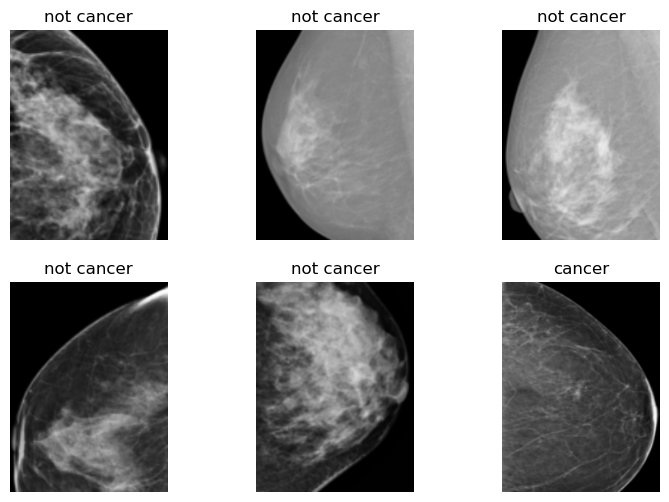

In [53]:
dls_f.show_batch(max_n=6)

In [55]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()
learn.fine_tune(1, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.153268,0.112268,0.018097,50:47


epoch,train_loss,valid_loss,error_rate,time
0,0.122012,0.089759,0.018006,44:31


In [57]:

files_n = get_image_files(data_small_train_path)

In [ ]:
files_n

- With resize images it still takes 50 minutes. Let's try to create a smaller dataset with symbolic links
- But I want to creaet a dataset where the distribution of images is same as actual dataset
- Stratify split will be the best option

# Creating splits for training and validation

In [59]:
df_train.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_name
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006_462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006_1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,10006_1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,10006_1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,10011_220375232.png


In [88]:
df_p = (
        df_train
        .groupby('patient_id')['cancer'].max()
        .reset_index()
       )
df_p

,patient_id,cancer
0,5,0
1,25,0
2,28,0
3,30,0
4,33,0
...,...,...
11908,65518,0
11909,65525,0
11910,65526,0
11911,65530,0


In [157]:
files_n[0].name

'10006_1459541791.png'

In [ ]:
train_test_split

- `StratifiedSplitData` will be spliting data but the distrubtion will be same
- The problem with that we can not get small dataset

In [26]:
@dataclass
class StratifiedSplitData:

    num_splits:int
    X:str # column name for X
    Y:str # column name for Y which needs to be stratified
    df_p:pd.DataFrame=field(repr=False) # dataframe with X and Y for stratification
    df_t:pd.DataFrame=field(repr=False) # dataframe with all images
    train_path:Path=field(repr=False) # path to train images
    shuffle_d:bool=True # shuffle data or not
    random_state_:int=42 # random state

    def __post_init__(self):
        skf = StratifiedKFold(
                              n_splits=self.num_splits,
                              shuffle=self.shuffle_d,
                              random_state=self.random_state_)
        self.splits = list(
                            skf.split(
                                self.df_t[self.X],
                                self.df_t[self.Y])
                          )
    def __getitem__(
                    self,
                    idx:int,
                    )->Tuple[List[str], List[str]]:

        trn_idx, val_idx = self.splits[idx]
        trn_lbl, val_lbl = self.df_t.loc[trn_idx, self.Y], self.df_t.loc[val_idx, self.Y]
        trn_img, val_img = self.df_t.loc[trn_idx, self.X], self.df_t.loc[val_idx, self.X]
        trn_img = [self.train_path/i for i in trn_img.values]
        val_img = [self.train_path/i for i in val_img.values]

        return (trn_img, trn_lbl.values),(val_img, val_lbl.values)

In [27]:
stry= StratifyYSplitData(
                   num_splits=5,
                   X='image_name',
                   Y='label',
                   df_t=df_t,
                   train_path=data_train_path)

TypeError: StratifyYSplitData.__init__() got an unexpected keyword argument 'num_splits'

In [208]:
(x_tr, x_l), (y_tr, y_val) = stry[0]

TypeError: 'StratifyYSplitData' object is not subscriptable

In [80]:
@dataclass
class StratifyYSplitData:

    X:str # column name for X
    Y:str # column name for Y which needs to be stratified
    df_t:pd.DataFrame=field(repr=False) # dataframe with all images and context data
    train_path:Path=field(repr=False) # path to train images
    shuffle_d:bool=True # shuffle data or not
    random_state_:int=42 # random state
    test_size:float=0.2 # test size

    def __post_init__(self):
        self.x_trn,  self.x_tst, self.y_trn, self.y_tst = train_test_split(
                                                                         self.df_t[self.X].values,
                                                                         self.df_t[self.Y].values,
                                                                         test_size=self.test_size,
                                                                         stratify=self.df_t[self.Y].values
                                                                         )
    def get_data(
                    self,
                    )->Tuple[List[str], List[int], List[str], List[int]]:
        trn_img = [self.train_path/str(i) for i in self.x_trn]
        trn_lbl = self.y_trn
        val_img = [self.train_path/str(i) for i in self.x_tst]
        val_lbl = self.y_tst

        return (trn_img, trn_lbl), (val_img, val_lbl)

    def __getitem__(self, idx:int)->Tuple[List[str], List[int]]:
        if idx == 0:
            (trn_img, trn_lbl), (_, _) = self.get_data()
            return trn_img, trn_lbl
        else:
            (_, _), (val_img, val_lbl) = self.get_data()
            return val_img, val_lbl
    
    def get_label_dict(
                       self,
                       data_list:str,
                       image_list:List[Path]
                       )->Dict[int, str]:
        
        if data_list == 'train':
            x, y = self[0]
            #print(x)
            return {i:j for i,j in zip(x,y)}

        elif data_list == 'valid':
            x, y = self[1]
            return {i:j for i,j in zip(x, y)}

        else:
            root_path = image_list[0].parent
            im_name_list = [Path(i).name for i in image_list]

            x,y = self[0]
            actual_dic =  {i.name:j for i,j in zip(x, y) if Path(i).name in im_name_list}
            return {k:v for k,v in actual_dic.items()}



                    
        



In [81]:
def create_small_dataset(
                        #source_:Path, # Present image path
                        destination_:Path, # new image path where small dataset will be created
                        image_list:List[Path], # list of images to be copied
                        symlink_:bool=False, # whether to create symlink or copy
                        )->None:
    """
    Creates a small dataset for faster training
    """
    destination_.mkdir(exist_ok=True, parents=True)


    if symlink_:
        print(f"Creating symbolic link of {len(image_list)} images in {destination_}")

        [Path(f'{destination_}/{i.name}').symlink_to(i) for i in image_list if not (destination_/i.name).exists()]

        print(f' number of files found in {destination_} == {len(destination_.ls())}')
    else:
        print(f"Copying ... {len(image_list)} images in {destination_}")
        [shutil.copyfile(i, f'{destination_}/{i.name}') for i in image_list]
        print(f' number of files found in {destination_} == {len(destination_.ls())}')


In [30]:
data_symlink

Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/data_symlink')

In [82]:
data_small_path = Path(r'/mnt/d/kaggle/breast_cancer/data_small')
data_small_path.mkdir(exist_ok=True, parents=True)


In [83]:
data_small_train_path

Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small')

In [84]:
strY = StratifyYSplitData(
                        X='image_name', 
                        Y='cancer',
                        df_t=df_t,
                        train_path=data_small_train_path,
                        test_size=0.9)

(xtrn, ytrn), (xval, yval) = strY.get_data()

print(f' Training size = {len(xtrn)},  and validation size = {len(xval)}')


 Training size = 5470,  and validation size = 49236


In [85]:
data_small_train_path

Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small')

In [86]:
L(xtrn)

(#5470) [Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/37281_1004478312.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/47118_1813299333.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/12596_574461995.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/30015_1966960463.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/2364_1574209525.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/33954_1980607998.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/15728_904416852.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/44143_1187012479.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/2546_730952035.png'),Path('/mnt/d/Kaggle/breast_cancer/data/bc_768_roi/train_small/12651_1852393673.png')...]

In [88]:
data_symlink_path = Path(r'/home/hasan/workspace/data/symlink/')

In [95]:

print(f' creating small dataset for training')
create_small_dataset(
                    #image_path=data_small_train_path,
                    destination_=data_symlink_path,
                    image_list=xtrn,
                    symlink_=True)

 creating small dataset for training
Creating symbolic link of 5470 images in /home/hasan/workspace/data/symlink
 number of files found in /home/hasan/workspace/data/symlink == 5470


In [90]:
#create_small_dataset(
                    ##image_path=data_small_train_path,
                    #destination_=data_symlink_path,
                    #image_list=xtrn,
                    #symlink_=True)

In [91]:
data_small_path

Path('/mnt/d/kaggle/breast_cancer/data_small')

In [96]:
fn = get_image_files(data_symlink_path)
#fn_a = get_image_files(data_small_path)

In [94]:
data_symlink_path

Path('/home/hasan/workspace/data/symlink')

In [97]:
fn

(#5470) [Path('/home/hasan/workspace/data/symlink/41203_1321652349.png'),Path('/home/hasan/workspace/data/symlink/27429_278619035.png'),Path('/home/hasan/workspace/data/symlink/6391_508036881.png'),Path('/home/hasan/workspace/data/symlink/47450_623328503.png'),Path('/home/hasan/workspace/data/symlink/6699_10619959.png'),Path('/home/hasan/workspace/data/symlink/43629_1681642361.png'),Path('/home/hasan/workspace/data/symlink/26380_1100193755.png'),Path('/home/hasan/workspace/data/symlink/29489_398240859.png'),Path('/home/hasan/workspace/data/symlink/33999_781784565.png'),Path('/home/hasan/workspace/data/symlink/15506_1058941561.png')...]

In [98]:
trn_dict = strY.get_label_dict(
                               data_list='small',
                               image_list=fn)

In [73]:
trn_dict = strY.get_label_dict(
                               data_list='small',
                               image_list=fn)

In [99]:
trn_dict

{'37281_1004478312.png': 0,
 '47118_1813299333.png': 0,
 '12596_574461995.png': 0,
 '30015_1966960463.png': 0,
 '2364_1574209525.png': 0,
 '33954_1980607998.png': 0,
 '15728_904416852.png': 0,
 '44143_1187012479.png': 0,
 '2546_730952035.png': 0,
 '12651_1852393673.png': 1,
 '29341_391257822.png': 0,
 '36053_1151808775.png': 0,
 '41616_1996777900.png': 0,
 '49180_1340803295.png': 0,
 '57440_1470203682.png': 0,
 '24243_1893171117.png': 0,
 '4503_1765886214.png': 0,
 '54316_745423796.png': 0,
 '35608_2048880273.png': 0,
 '9513_1613162698.png': 0,
 '2625_1092470420.png': 0,
 '17411_1335858268.png': 0,
 '6685_133692434.png': 0,
 '20744_653337921.png': 0,
 '58202_1123015644.png': 0,
 '48493_1325590980.png': 0,
 '46422_623876079.png': 0,
 '4558_130804718.png': 0,
 '61226_2012248370.png': 0,
 '58124_1376065330.png': 0,
 '40143_887509577.png': 0,
 '58006_931195893.png': 0,
 '4441_342062970.png': 0,
 '48808_479838007.png': 0,
 '29414_657579576.png': 0,
 '5766_1319131899.png': 0,
 '60537_2110228

In [75]:

def label_func(x):
    return trn_dict[x.name]  

In [79]:
[i for i in trn_dict.keys() if i not in fn]

['15639_1944241267.png',
 '59588_1005459220.png',
 '20971_618030178.png',
 '22826_907556597.png',
 '56554_1768148287.png',
 '33041_973014301.png',
 '22900_63663792.png',
 '48761_328497515.png',
 '11409_1619822516.png',
 '54832_1655318553.png',
 '17675_1250831238.png',
 '33411_1413492927.png',
 '12453_569946983.png',
 '26832_1527312265.png',
 '47328_394607461.png',
 '61769_1751453575.png',
 '47540_208493514.png',
 '7755_1638735290.png',
 '45005_820538925.png',
 '48171_2064701941.png',
 '52857_1461033160.png',
 '58594_432511239.png',
 '21055_624261199.png',
 '16883_706548483.png',
 '30330_362633763.png',
 '12195_100147863.png',
 '51276_711908647.png',
 '22334_675214433.png',
 '46349_692987985.png',
 '43843_623907172.png',
 '10273_966712981.png',
 '36714_1351439622.png',
 '38667_951790766.png',
 '4998_2057362976.png',
 '33620_1540681877.png',
 '47473_964029413.png',
 '49236_948283053.png',
 '3277_1556003370.png',
 '40201_1240619560.png',
 '5028_1611890082.png',
 '59410_538742699.png',
 '5

In [100]:
dls_ff = ImageDataLoaders.from_path_func(
                                      data_symlink_path,
                                      fnames=fn,
                                      label_func=label_func,
                                      item_tfms=Resize(43),
                                      batch_tfms=aug_transforms(size=43, min_scale=.75),
                                 
                                      valid_pct=0.2,
                                      seed=42,
                                      )
dls_ff.device = default_device()

In [101]:
trn_dict

{'37281_1004478312.png': 0,
 '47118_1813299333.png': 0,
 '12596_574461995.png': 0,
 '30015_1966960463.png': 0,
 '2364_1574209525.png': 0,
 '33954_1980607998.png': 0,
 '15728_904416852.png': 0,
 '44143_1187012479.png': 0,
 '2546_730952035.png': 0,
 '12651_1852393673.png': 1,
 '29341_391257822.png': 0,
 '36053_1151808775.png': 0,
 '41616_1996777900.png': 0,
 '49180_1340803295.png': 0,
 '57440_1470203682.png': 0,
 '24243_1893171117.png': 0,
 '4503_1765886214.png': 0,
 '54316_745423796.png': 0,
 '35608_2048880273.png': 0,
 '9513_1613162698.png': 0,
 '2625_1092470420.png': 0,
 '17411_1335858268.png': 0,
 '6685_133692434.png': 0,
 '20744_653337921.png': 0,
 '58202_1123015644.png': 0,
 '48493_1325590980.png': 0,
 '46422_623876079.png': 0,
 '4558_130804718.png': 0,
 '61226_2012248370.png': 0,
 '58124_1376065330.png': 0,
 '40143_887509577.png': 0,
 '58006_931195893.png': 0,
 '4441_342062970.png': 0,
 '48808_479838007.png': 0,
 '29414_657579576.png': 0,
 '5766_1319131899.png': 0,
 '60537_2110228

In [495]:
sizes = parallel(f, fn, n_workers=8)

In [500]:
np.min(pd.Series(sizes).value_counts(ascending=True).index)

(43, 256)

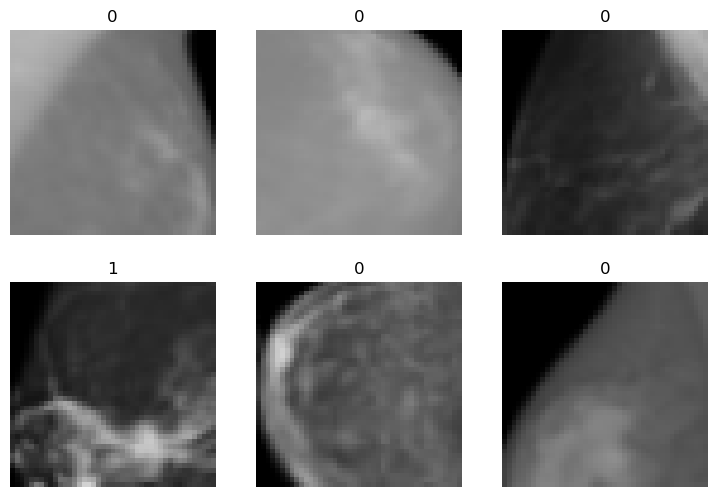

In [102]:

dls_ff.show_batch(max_n=6)

In [104]:
learn = vision_learner(dls_ff, 'resnet26d', metrics=error_rate, path='.').to_fp16()


SuggestedLRs(valley=0.009120108559727669, slide=0.015848932787775993)

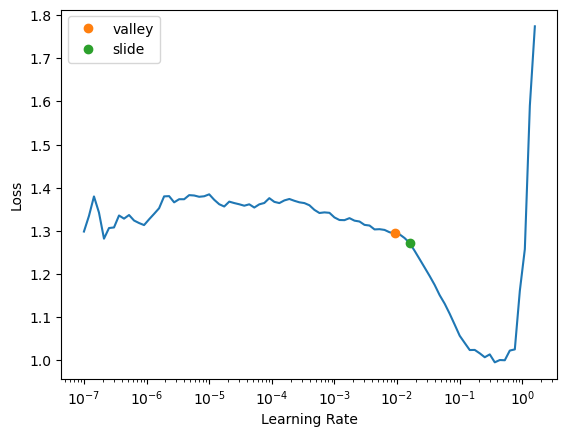

In [105]:
learn.lr_find(suggest_funcs=(valley, slide))

In [106]:
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,error_rate,time
0,0.494576,0.199467,0.032907,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.187019,0.177205,0.021938,00:18
1,0.173621,0.167019,0.024680,00:21
2,0.128474,0.139623,0.021938,00:24


In [ ]:
data_small_path

In [102]:
def split_data(
              n_s:int, # number of splits 
              df_p:pd.DataFrame, # dataframe with X and Y
              X:str, # column name for X
              Y:str, # column name for Y which needs to be stratified
              shuffle_d:bool=True, # shuffle data or not
              random_state_:int=42 # random state
              )->SplitData:
    
    skf = StratifiedKFold(
                    n_splits=n_s,
                    shuffle=shuffle_d,
                    random_state=random_state_)

    splits = list(skf.split(
                    df_p[X],
                    y=df_p[Y])
                    )
    return splits

In [87]:
sp = split_data(
           n_s=5,
           df_p=df_p,
           X='patient_id',
           Y='cancer',
           shuffle_d=True,
           )
sp

[(array([    0,     1,     3, ..., 11910, 11911, 11912]),
  array([    2,     8,    22, ..., 11901, 11905, 11907])),
 (array([    0,     1,     2, ..., 11910, 11911, 11912]),
  array([    3,     5,    11, ..., 11897, 11903, 11906])),
 (array([    0,     1,     2, ..., 11908, 11910, 11911]),
  array([    4,    12,    13, ..., 11904, 11909, 11912])),
 (array([    2,     3,     4, ..., 11909, 11911, 11912]),
  array([    0,     1,     9, ..., 11899, 11902, 11910])),
 (array([    0,     1,     2, ..., 11909, 11910, 11912]),
  array([    6,     7,    15, ..., 11900, 11908, 11911]))]

In [ ]:
def get_split(
             n:int,
             splits:SplitData):
    train_idx, valid_idx = splits[n]
    train_image, valid_image = df_p.loc[train_idx, 'image_name'], df_p.loc[valid_idx,'image_name']
    return train_image, valid_image

In [90]:
fn_2_label ={fn:l for fn, l in zip(df_t['image_name'], df_t['label'])}

In [58]:
interp = ClassificationInterpretation.from_learner(learn)

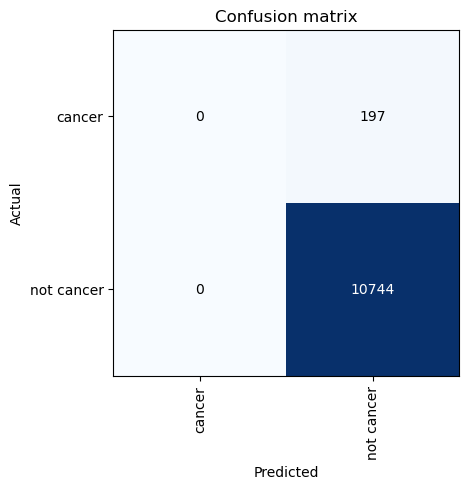

In [68]:
interp.plot_confusion_matrix()

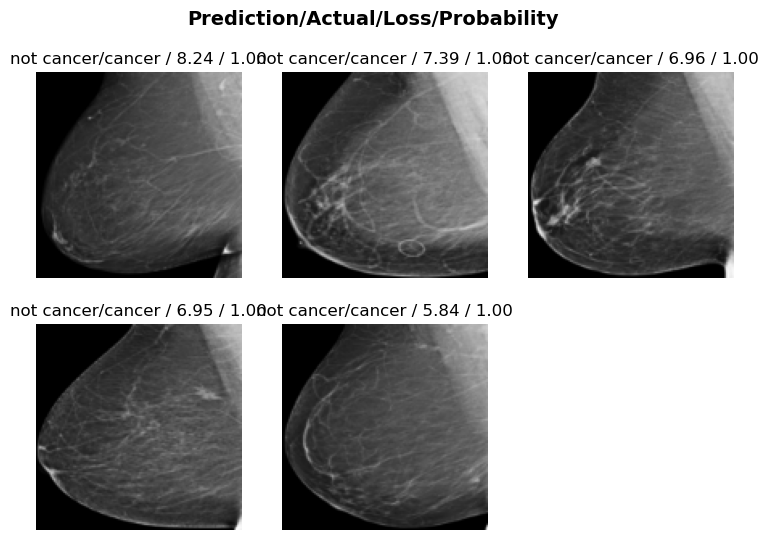

In [70]:
interp.plot_top_losses(k=5)

In [71]:
tst_files = get_image_files(data_test_path)
tst_dl = dls.test_dl(tst_files)

In [72]:
probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([1, 1, 1, 1])

In [ ]:
dls.vocab

In [ ]:
df_test = pd.read_csv(data_test_path)
df_test

In [ ]:
166, 166

In [ ]:
390, 768

In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()